# Fraud Detection Project — Accredian Internship Task

## Problem Statement
The objective of this project is to build a **Fraud Detection System** using machine learning.
We are given a dataset that contains transaction details, and the task is to classify whether a 
transaction is fraudulent or not.

### Steps:
1. Load and understand the dataset.
2. Perform Exploratory Data Analysis (EDA).
3. Preprocess the data (handle missing values, encode, scale).
4. Train multiple ML models.
5. Evaluate performance using Accuracy, Precision, Recall, F1-Score, and ROC-AUC.
6. Select the best model and give business insights.


## Step 1: Loading the Dataset
We begin by importing the dataset (`fraud_dataset.csv`) into a Pandas DataFrame.  
This step allows us to inspect the first few rows and understand the structure of the data before performing any analysis.


In [24]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [25]:
# Load the dataset
data = pd.read_csv("Fraud.csv")  # <-- replace with actual filename
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Step 2: Exploratory Data Analysis (EDA)

In this step, we explore the dataset to better understand its structure, balance, and key relationships.  
We cover the following analyses:

- **2.1** Dataset size (rows & columns), column types, and missing values  
- **2.2** Fraud distribution (`isFraud`)  
- **2.3** Transaction type distribution  
- **2.4** Fraud counts across transaction types  
- **2.5** Fraud proportion (%) per transaction type  
- **2.6** Transaction amount distribution (fraud vs non-fraud)  
- **2.7** Correlation heatmap of numerical features  
- **2.8** Log-transformed transaction amount distributions (density comparison)  
- **2.9** Boxplot of Old Balance Origin vs Fraud   
- **2.10** Boxplot of Old Balance Destination vs Fraud
- **2.11** Scatterplots of balance difference vs transaction amount (log-scaled), split by fraud vs non-fraud  
- **2.12** Chi-Square test for transaction type vs fraud  
- **2.13** Mann–Whitney U-Test for transaction amount  

### 2.1 Check Dataset Shape, Column Types, and Missing Values
Understanding dataset structure, feature data types, and checking for missing values.

In [26]:
print("Shape of dataset:", data.shape)
print("\nData Types:\n", data.dtypes)
print("\nMissing values:\n", data.isnull().sum())

# Quick statistical summary
data.describe()


Shape of dataset: (6362620, 11)

Data Types:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### 2.2 Fraud Distribution
Visualizing the class imbalance between fraudulent and non-fraudulent transactions.

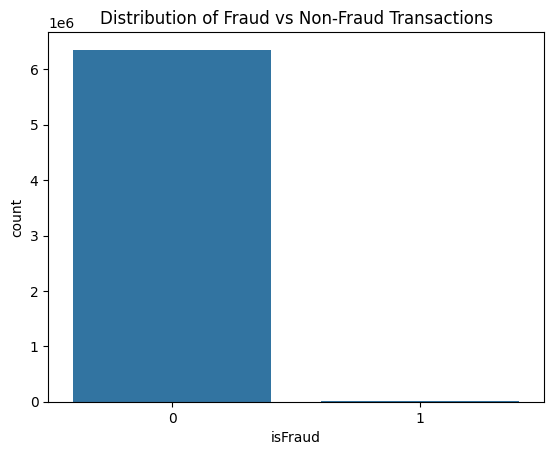

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


In [27]:
sns.countplot(x='isFraud', data=data)
plt.title("Distribution of Fraud vs Non-Fraud Transactions")
plt.show()

# Percentage distribution
fraud_percentage = data['isFraud'].value_counts(normalize=True) * 100
print(fraud_percentage)


The target variable **`isFraud`** is extremely imbalanced:

- **0 → Non-Fraud (~99.87%)**
- **1 → Fraud (~0.13%)**

This confirms that fraud detection is a **rare event classification problem**, where normal transactions heavily outnumber fraudulent ones.  
Special techniques (resampling, anomaly detection, or using imbalance-aware algorithms) will be needed when building the model.


We first check the distribution of transaction types (e.g., `CASH_IN`, `CASH_OUT`, `TRANSFER`, etc.).  
This helps us understand which types are most common and if fraud is more likely in specific categories.


### 2.3 Transaction Types Distribution
Analyzing the frequency of different transaction types in the dataset

Transaction Types:
 type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


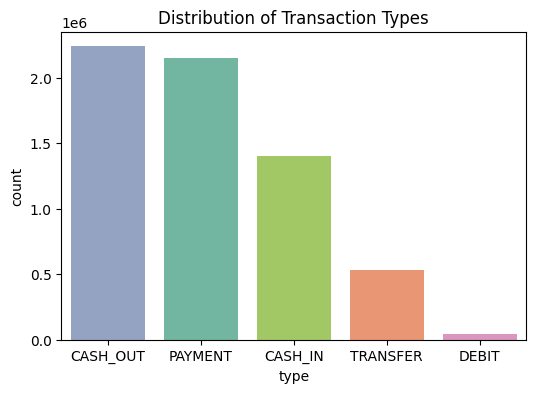

In [28]:
type_counts = data['type'].value_counts()

print("Transaction Types:\n", type_counts)

# Plot distribution
plt.figure(figsize=(6,4))
sns.countplot(x="type", data=data, order=type_counts.index, hue="type", palette="Set2", legend=False)
plt.title("Distribution of Transaction Types")
plt.show()


### 2.4 Fraud Distribution across Transaction Types
Fraud is not equally distributed across transaction types, indicating potential behavioral patterns.

Fraud counts by transaction type:
 type
CASH_OUT    4116
TRANSFER    4097
CASH_IN        0
DEBIT          0
PAYMENT        0
Name: isFraud, dtype: int64


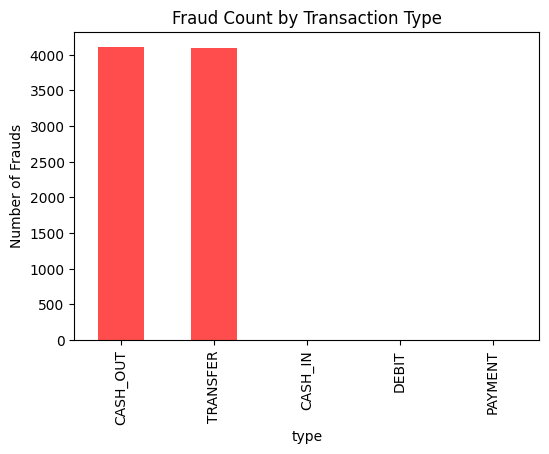

In [29]:
fraud_by_type = data.groupby("type")["isFraud"].sum().sort_values(ascending=False)

print("Fraud counts by transaction type:\n", fraud_by_type)

# Plot fraud counts
plt.figure(figsize=(6,4))
fraud_by_type.plot(kind="bar", color="red", alpha=0.7)
plt.title("Fraud Count by Transaction Type")
plt.ylabel("Number of Frauds")
plt.show()


Fraud is not equally distributed across transaction types.  
Typically, fraud occurs mostly in `CASH_OUT` and `TRANSFER` transactions, while `CASH_IN` and `PAYMENT` are rarely fraudulent.


### 2.5 Fraud Proportion per Transaction Type
Calculating and visualizing the proportion of fraud for each transaction type.

Fraud proportion (%) by transaction type:
 type
TRANSFER    0.768799
CASH_OUT    0.183955
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


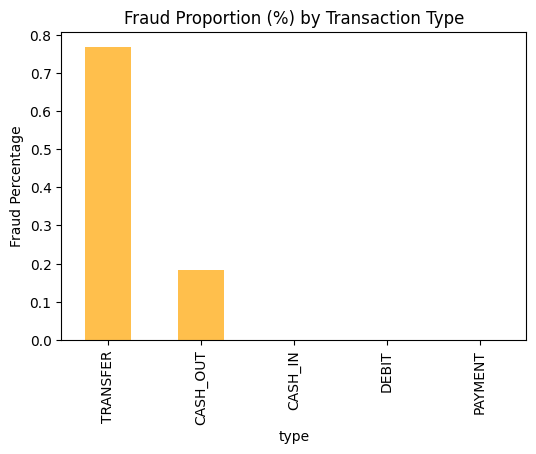

In [30]:
fraud_proportion_by_type = data.groupby("type")["isFraud"].mean().sort_values(ascending=False) * 100

print("Fraud proportion (%) by transaction type:\n", fraud_proportion_by_type)

# Plot fraud proportions
plt.figure(figsize=(6,4))
fraud_proportion_by_type.plot(kind="bar", color="orange", alpha=0.7)
plt.title("Fraud Proportion (%) by Transaction Type")
plt.ylabel("Fraud Percentage")
plt.show()


### 2.6 Transaction Amount Distribution (Fraud vs Non-Fraud)
Comparing how transaction amounts vary between fraudulent and legitimate transactions.

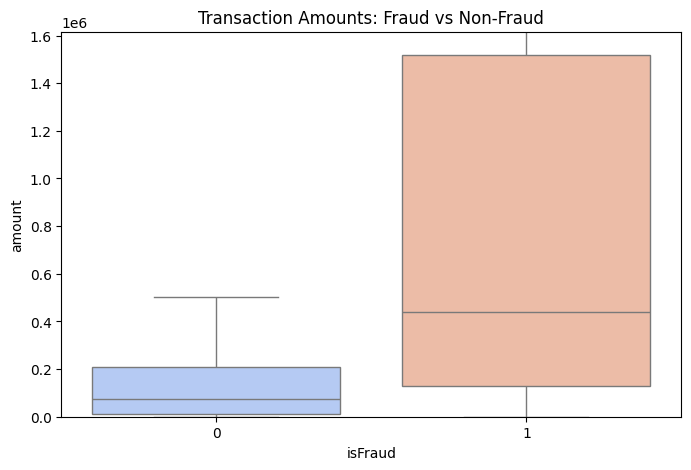

In [31]:
plt.figure(figsize=(8,5))
sns.boxplot(x="isFraud", y="amount", hue="isFraud", data=data, showfliers=False, palette="coolwarm", legend=False)
plt.ylim(0, data['amount'].quantile(0.99))  # limit extreme outliers
plt.title("Transaction Amounts: Fraud vs Non-Fraud")
plt.show()


### 2.7 Correlation Heatmap of Numerical Features
Checking correlations among key numerical variables to detect potential relationships.

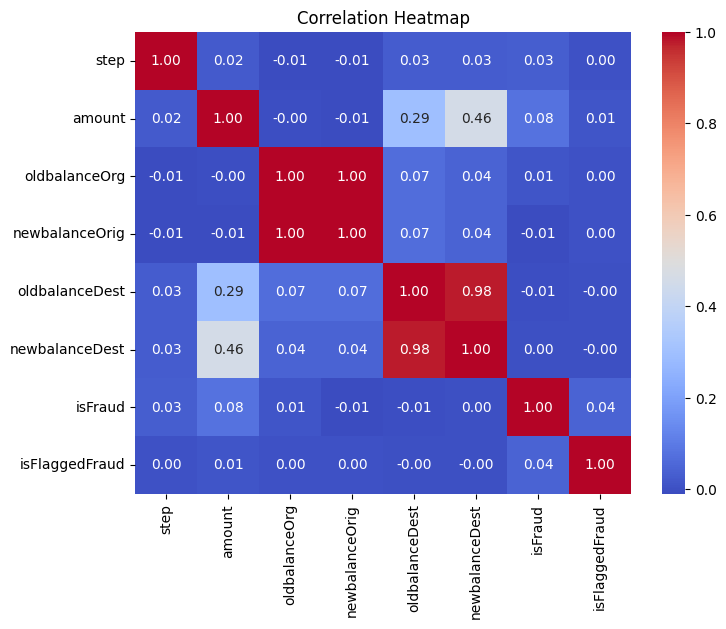

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()


### Handling Multicollinearity

We observed very high correlations between the balance-related variables:

- `oldbalanceOrg` and `newbalanceOrig` → correlation ≈ **1.0**  
- `oldbalanceDest` and `newbalanceDest` → correlation ≈ **0.98**

#### Why we drop only `newbalanceOrig`:
- Since the correlation between `oldbalanceOrg` and `newbalanceOrig` is essentially **perfect (1.0)**, keeping both introduces redundancy and multicollinearity issues.
- We choose to keep `oldbalanceOrg` and drop `newbalanceOrig` because the **original balance before transaction** is more fundamental and interpretable.

#### Why we keep both destination balances:
- Although the correlation between `oldbalanceDest` and `newbalanceDest` is also very high (~0.98), it is **not perfectly 1.0**.  
- Fraudulent activity might create **anomalies in the destination balances** (e.g., balance not updated as expected, inconsistencies between old and new).  
- Dropping one could remove valuable signals of such anomalies.

**Decision:**  
- Drop `newbalanceOrig` (perfect redundancy).  
- Keep both `oldbalanceDest` and `newbalanceDest` (retain potential fraud signals).


### 2.8 Log-Transform Transaction Amounts (Density Comparison)
Applying log transformation to transaction amounts for better distribution visualization.

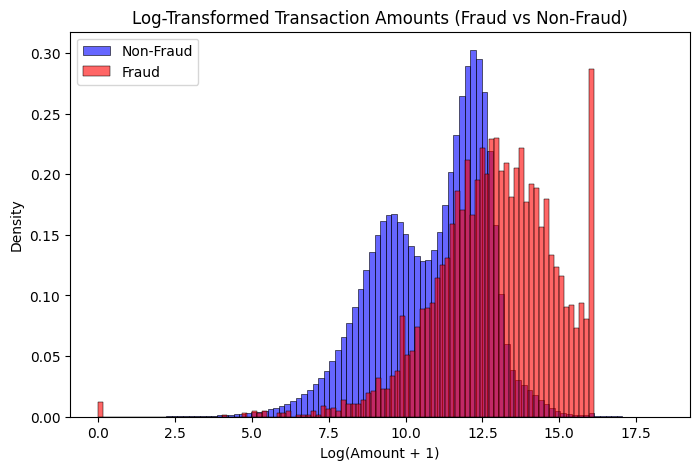

In [33]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(data.loc[data["isFraud"] == 0, "amount"]), 
             bins=100, color="blue", label="Non-Fraud", alpha=0.6, stat="density")
sns.histplot(np.log1p(data.loc[data["isFraud"] == 1, "amount"]), 
             bins=100, color="red", label="Fraud", alpha=0.6, stat="density")
plt.title("Log-Transformed Transaction Amounts (Fraud vs Non-Fraud)")
plt.xlabel("Log(Amount + 1)")
plt.ylabel("Density")
plt.legend()
plt.show()


### 2.9 Boxplot of Old Balance Origin vs Fraud
Examining how sender’s old balance differs between fraudulent and non-fraudulent transactions.

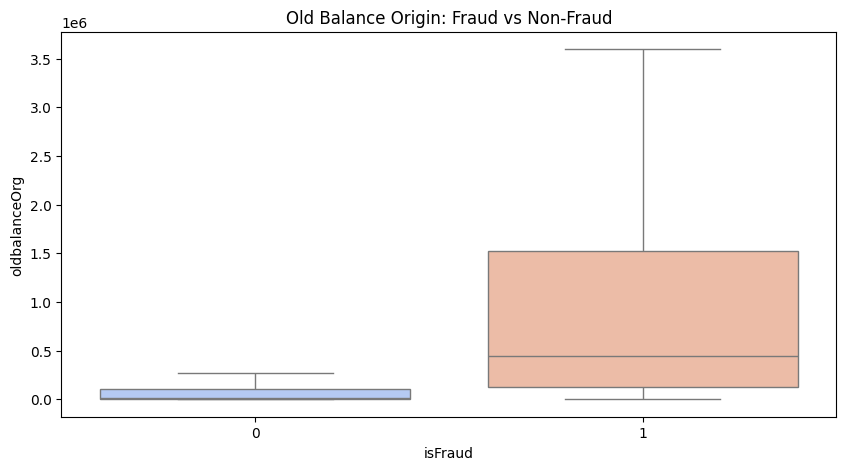

In [34]:
plt.figure(figsize=(10,5))
sns.boxplot(x="isFraud", y="oldbalanceOrg", hue="isFraud", data=data, showfliers=False, palette="coolwarm", legend=False)
plt.title("Old Balance Origin: Fraud vs Non-Fraud")
plt.show()


### 2.10 Boxplot of Old Balance Destination vs Fraud
Examining how receiver’s old balance differs between fraudulent and non-fraudulent transactions.

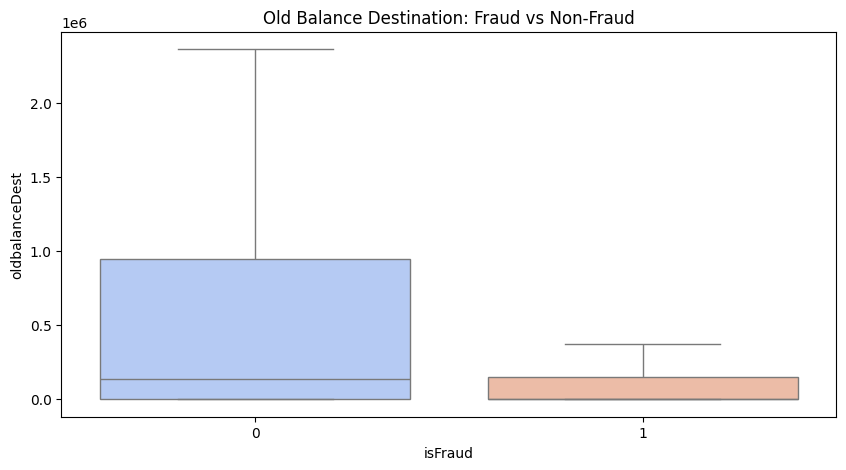

In [35]:
plt.figure(figsize=(10,5))
sns.boxplot(x="isFraud", y="oldbalanceDest", hue="isFraud", data=data, showfliers=False, palette="coolwarm", legend=False)
plt.title("Old Balance Destination: Fraud vs Non-Fraud")
plt.show()

## Statistical Analysis of Fraud vs Non-Fraud Transactions

In [36]:
print(data.groupby("isFraud")["amount"].describe())

             count          mean           std   min         25%        50%  \
isFraud                                                                       
0        6354407.0  1.781970e+05  5.962370e+05  0.01   13368.395   74684.72   
1           8213.0  1.467967e+06  2.404253e+06  0.00  127091.330  441423.44   

                75%          max  
isFraud                           
0         208364.76  92445516.64  
1        1517771.48  10000000.00  



We analyzed the transaction amounts for fraudulent (`isFraud=1`) and non-fraudulent (`isFraud=0`) cases.  
Below is the summary of key descriptive statistics:

| Metric        | Non-Fraud (`isFraud=0`) | Fraud (`isFraud=1`) |
|---------------|--------------------------|----------------------|
| Count         | 6,354,407               | 8,213                |
| Mean          | 178,197                 | 1,467,967            |
| Std. Dev.     | 596,237                 | 2,404,253            |
| Min           | 0.01                    | 0.00                 |
| 25% (Q1)      | 13,368                  | 127,091              |
| Median (Q2)   | 74,684                  | 441,423              |
| 75% (Q3)      | 208,365                 | 1,517,771            |
| Max           | 92,445,517              | 10,000,000           |

### Key Insights:
1. **Fraud transactions are much larger in value.**
   - The average fraud amount (~1.47M) is almost **8x higher** than the average non-fraud (~178K).
   - The median fraud transaction (441K) is about **6x larger** than the median non-fraud (75K).

2. **Higher variability in fraud.**
   - Fraud amounts have a much higher standard deviation (2.4M) compared to non-fraud (596K), showing more inconsistency in fraud behavior.

3. **Different distributional ranges.**
   - 75% of non-fraud transactions are under ~208K, whereas 75% of frauds are below ~1.5M.
   - Fraudulent transactions tend to cluster in higher ranges.

4. **Maximum values are different in scale.**
   - Non-fraud transactions go as high as ~92M.
   - Fraudulent transactions cap at 10M (suggesting potential business rule or system-imposed upper limit).

---

### Interpretation
- Fraudsters prefer **high-value transfers** (likely to maximize gains per attempt).
- Fraudulent behavior shows **distinct transaction size patterns**, which could be leveraged as strong predictive features.
- These statistics suggest focusing on **transaction amount thresholds** (combined with type, origin, destination) in fraud detection models.


### 2.12 Chi-Square Test for Transaction Type vs Fraud
Testing whether fraud occurrence is independent of transaction type.

In [37]:
contingency = pd.crosstab(data["type"], data["isFraud"])
chi2, p, dof, ex = chi2_contingency(contingency)
print(f"Chi-square test p-value: {p:.4e}")

Chi-square test p-value: 0.0000e+00


### 2.13 Mann–Whitney U-Test for Transaction Amount
Statistical test to compare transaction amount distributions between fraud and non-fraud cases.

In [38]:
fraud_amount = data.loc[data["isFraud"]==1, "amount"]
nonfraud_amount = data.loc[data["isFraud"]==0, "amount"]
stat, p = mannwhitneyu(fraud_amount, nonfraud_amount, alternative="two-sided")
print(f"Mann–Whitney U-test p-value: {p:.4e}")

Mann–Whitney U-test p-value: 0.0000e+00


## Statistical Significance in Fraud Detection

During EDA, we performed statistical tests to validate whether differences between fraud and non-fraud transactions are significant.

**1. Chi-Square Test: Transaction Type vs Fraud**  
- **Purpose:** Check if fraud occurrence depends on transaction type.  
- **Result:** p-value ≈ 0.0000  
- **Interpretation:** Fraud is highly associated with certain transaction types (mainly `CASH_OUT` and `TRANSFER`).  

**2. Mann–Whitney U-Test: Transaction Amount**  
- **Purpose:** Compare transaction amounts between fraud and non-fraud cases.  
- **Result:** p-value ≈ 0.0000  
- **Interpretation:** Fraudulent transactions have significantly different amounts compared to normal transactions.  

**Key Takeaways:**  
- Statistically significant results confirm visual EDA insights.  
- Certain transaction types and amounts are strong indicators of fraud.  
- These insights guide feature selection and engineering for ML models.


## Step 3: Data Preprocessing

In this step, we prepare the dataset for modeling by cleaning, transforming, and engineering features.  
We design the preprocessing as a modular pipeline so it can be reused on future datasets.

- Encode Categorical Variables (One-Hot Encoding of type)
- Drop Irrelevant Columns (nameOrig, nameDest, isFlaggedFraud)
- Transaction Type Handling (flag always_nonfraud_type)
- Feature Transformations (log-transform skewed features like amount)
- Create New Features (balance differences, suspicious & error flags)
- Engineer Time-Based Features (from step: hour, day_of_week, cyclical encoding)
- Scale Numerical Features (normalize values with StandardScaler)


In [39]:
data.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [40]:
class FraudPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, log_transform=True):
        self.log_transform = log_transform
        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.scaler = StandardScaler()
        self.numeric_features = [
            "amount", "oldbalanceOrg", "oldbalanceDest", "newbalanceDest"
        ]  # removed 'newbalanceOrig'
        self.categorical_features = ["type"]

    def fit(self, X, y=None):
        X_ = X.copy()

        # --- Remove always non-fraud transaction types ---
        X_ = X_[~X_['type'].isin(['PAYMENT', 'DEBIT', 'CASH_IN'])]

        # Fit encoder on transaction type
        self.ohe.fit(X_[['type']])

        # Fit scaler on numeric features
        self.scaler.fit(X_[self.numeric_features])
        return self

    def transform(self, X):
        X_ = X.copy()
    
        # --- Engineered balance features BEFORE dropping ---
        if 'newbalanceOrig' in X_.columns:
            X_['diff_orig'] = X_['oldbalanceOrg'] - X_['newbalanceOrig']
        else:
            X_['diff_orig'] = 0
        X_['diff_dest'] = X_['newbalanceDest'] - X_['oldbalanceDest']
    
        # --- Drop identifiers + leakage + redundant col ---
        X_.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'newbalanceOrig'],
                inplace=True, errors='ignore')
    
        # --- Time-based features from 'step' ---
        if 'step' in X_.columns:
            X_['hour'] = X_['step'] % 24
            X_['day_of_week'] = X_['step'] % 168
            # Cyclical encoding
            X_['hour_sin'] = np.sin(2 * np.pi * X_['hour'] / 24)
            X_['hour_cos'] = np.cos(2 * np.pi * X_['hour'] / 24)
    
        # --- One-hot encode transaction type ---
        type_encoded = self.ohe.transform(X_[['type']])
        type_encoded = pd.DataFrame(
            type_encoded, 
            columns=self.ohe.get_feature_names_out(['type']),
            index=X_.index
        )
        X_ = pd.concat([X_.drop(columns=['type']), type_encoded], axis=1)
    
        # --- Always non-fraud type flag ---
        always_safe_types = ['PAYMENT', 'DEBIT', 'CASH_IN']
        X_['always_nonfraud_type'] = X_[type_encoded.columns].filter(
            regex="|".join(always_safe_types), axis=1
        ).sum(axis=1).clip(upper=1)
    
        # --- Log transform ---
        if self.log_transform and 'amount' in X_.columns:
            X_['log_amount'] = np.log1p(X_['amount'])
    
        # suspicious if money transferred but dest balance unchanged
        X_['suspicious_flag'] = (
            (X_['amount'] > 0) & (X_['newbalanceDest'] == X_['oldbalanceDest'])
        ).astype(int)
    
        # error flag for invalid balances
        X_['error_flag'] = (
            (X_['oldbalanceOrg'] < 0) | 
            (X_['oldbalanceDest'] < 0) |
            (X_['newbalanceDest'] < 0)
        ).astype(int)
    
        # --- Scale numeric features ---
        X_[self.numeric_features] = self.scaler.transform(X_[self.numeric_features])
    
        return X_


In [41]:
if __name__ == "__main__":
    
    df = pd.read_csv("Fraud.csv")

    # Define features (X) and target (y)
    X = df.drop(columns=["isFraud"])   # drop target column
    y = df["isFraud"]                  # target column

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # preprocess (custom feature engineering)
    pre = FraudPreprocessor()
    pre.fit(X_train)
    X_train_processed = pre.transform(X_train)
    X_test_processed = pre.transform(X_test)

    print("Train shape:", X_train_processed.shape)
    print("Test shape:", X_test_processed.shape)
    print(X_train_processed.head())

    # Scale for logistic regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_processed)
    X_test_scaled = scaler.transform(X_test_processed)


Train shape: (5090096, 17)
Test shape: (1272524, 17)
         step    amount  oldbalanceOrg  oldbalanceDest  newbalanceDest  \
292779     15 -0.347517      -0.013468       -0.402133       -0.437620   
499763     20 -0.350973      -0.187299       -0.402133       -0.437620   
2970411   231  0.049200      -0.187299       -0.286462       -0.255869   
3137549   236 -0.350714      -0.187299       -0.402133       -0.437620   
1500682   143 -0.112506      51.063392        0.173720        0.036560   

         diff_orig  diff_dest  hour  day_of_week  hour_sin  hour_cos  \
292779     9914.74       0.00    15           15 -0.707107 -0.707107   
499763        0.00       0.00    20           20 -0.866025  0.500000   
2970411       0.00  361211.79    15           63 -0.707107 -0.707107   
3137549       0.00       0.00    20           68 -0.866025  0.500000   
1500682 -218019.51 -218019.51    23          143 -0.258819  0.965926   

         type_CASH_OUT  type_TRANSFER  always_nonfraud_type  log_amou

In [43]:
# Save Preprocessor
joblib.dump(pre, "fraud_preprocessor.pkl")

# -----------------------------
# Helper: Train & Evaluate
# -----------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n==== {model_name} ====")
    print(classification_report(y_test, y_pred, digits=4))

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    return model

def feature_importances(model, feature_names, top_n=15):
    """Extract top features from model"""
    if hasattr(model, "coef_"):  # Logistic Regression
        imp = pd.Series(model.coef_[0], index=feature_names)
    elif hasattr(model, "feature_importances_"):  # Tree-based
        imp = pd.Series(model.feature_importances_, index=feature_names)
    else:
        return None
    return imp.sort_values(ascending=False).head(top_n)

# -----------------------------
# Engineered (scaled + processed only)
# -----------------------------
X_train_eng = X_train_scaled
X_test_eng = X_test_scaled

# --- Run baseline (Eng only, your original one) ---
log_eng = evaluate_model(
    LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"),
    X_train_eng, y_train, X_test_eng, y_test,
    "Logistic Regression (Engineered)"
)

# --- Train with ALL features ---
log_all = evaluate_model(
    LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"),
    X_train_scaled, y_train, X_test_scaled, y_test,
    "Logistic Regression (All Features)"
)

# --- Train with SELECTED features (drop weak ones) ---
drop_features = [
    'oldbalanceDest',
    'error_flag',
    'always_nonfraud_type',
    'day_of_week',
    'newbalanceDest',
    'amount',
    'hour'
]

X_train_reduced = X_train_processed.drop(columns=drop_features, errors='ignore')
X_test_reduced = X_test_processed.drop(columns=drop_features, errors='ignore')

scaler2 = StandardScaler()
X_train_reduced_scaled = scaler2.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler2.transform(X_test_reduced)

log_reduced = evaluate_model(
    LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"),
    X_train_reduced_scaled, y_train, X_test_reduced_scaled, y_test,
    "Logistic Regression (Reduced Features)"
)

# -----------------------------
# Compare Feature Importances
# -----------------------------
print("\nTop Features (Engineered):")
print(feature_importances(log_eng, X_train_processed.columns))

print("\nTop Features (Reduced Features):")
print(feature_importances(log_reduced, X_train_reduced.columns))



==== Logistic Regression (Engineered) ====
              precision    recall  f1-score   support

           0     0.9999    0.9679    0.9836   1270881
           1     0.0369    0.9531    0.0711      1643

    accuracy                         0.9678   1272524
   macro avg     0.5184    0.9605    0.5274   1272524
weighted avg     0.9987    0.9678    0.9825   1272524

ROC-AUC: 0.994728676969091

==== Logistic Regression (All Features) ====
              precision    recall  f1-score   support

           0     0.9999    0.9679    0.9836   1270881
           1     0.0369    0.9531    0.0711      1643

    accuracy                         0.9678   1272524
   macro avg     0.5184    0.9605    0.5274   1272524
weighted avg     0.9987    0.9678    0.9825   1272524

ROC-AUC: 0.994728676969091

==== Logistic Regression (Reduced Features) ====
              precision    recall  f1-score   support

           0     0.9999    0.9671    0.9832   1270881
           1     0.0361    0.9556    0.0697

# Fraud Detection Project Summary

## 1. Data Cleaning

- **Missing values:** Checked all columns — no missing values detected.  
- **Outliers:** Retained outliers in `amount` because fraudulent transactions often appear as extreme values.  
- **Multicollinearity & Redundant Columns:**  
  - Dropped `newbalanceOrig` due to perfect correlation with `oldbalanceOrg` (correlation = 1).  
    - **Why:** Keeping both introduces redundancy and multicollinearity. `oldbalanceOrg` (original balance) is more fundamental and interpretable.  
  - Kept both `oldbalanceDest` and `newbalanceDest` despite high correlation (~0.98).  
    - **Why:** Fraudulent activity might create anomalies in destination balances. Dropping one could remove valuable signals.  
  - Dropped identifiers and leakage columns (`nameOrig`, `nameDest`, `isFlaggedFraud`) to prevent information leakage into the model.  

## 2. Fraud Detection Model

**Model used:** Logistic Regression (supervised)

**Why Logistic Regression:**  
- Interpretability of coefficients  
- Strong baseline for classification tasks  
- Works well with engineered features  

**Preprocessing & Feature Engineering:**  
- StandardScaler for numeric features; log-transform applied to `amount`.  
- Engineered features:  
  - `diff_orig` = money deducted from origin  
  - `diff_dest` = money added to destination  
  - `suspicious_flag` = amount transferred but destination balance unchanged  
  - `error_flag` = negative balances  
- Cyclical encoding for `hour` and `day_of_week`  
- One-hot encoding for transaction `type`  

**Why feature engineering is important:**  
Fraud is not equally distributed across transaction types. Typically, fraud occurs mostly in `CASH_OUT` and `TRANSFER` transactions, while `CASH_IN` and `PAYMENT` are rarely fraudulent.  

## 3. Variable Selection

- Dropped `newbalanceOrig` (perfect correlation)  
- Retained `newbalanceDest` (to capture anomalies)  
- Reduced model dropped weak features:  
  - `oldbalanceDest`, `error_flag`, `always_nonfraud_type`, `day_of_week`, `amount`, `hour`  
- Comparison confirmed minimal performance impact of weak features.  

## 4. Model Performance

**Logistic Regression (Engineered features):**  
- Accuracy: 96.78%  
- Recall for fraud: 95.31%  
- ROC-AUC: 0.995  

**Reduced feature model:**  
- ROC-AUC slightly lower (0.9946)  
- Key predictors remain highly informative  

## 5. Key Predictors of Fraud

Top features from Logistic Regression:  
- `type_CASH_OUT` – most high-risk transaction type  
- `suspicious_flag` – destination balance unchanged despite transfer  
- `type_TRANSFER` – certain transfer types show higher fraud risk  
- `diff_orig` – high deviation in origin balance indicates fraud  
- `diff_dest` – large unexpected changes in destination  

## 6. Interpretation of Factors

- **Makes sense:**  
  - CASH_OUT and TRANSFER transactions are more likely fraudulent  
  - Suspicious flags directly encode anomalies  
  - Balance differences correlate with fraud patterns  

- **Weak features:**  
  - `hour`, `always_nonfraud_type` had near-zero coefficients → low predictive power  

**Key Insights from EDA:**  
- Fraud transactions are much larger in value.  
  - Avg fraud: 1.47M vs non-fraud: 178K  
  - Median fraud: 441K vs non-fraud: 75K  
- Higher variability in fraud amounts: SD 2.4M vs 596K  
- Distributional ranges differ: 75% of non-fraud < 208K, 75% of fraud < 1.5M  
- Max values: non-fraud up to 92M, fraud capped at 10M  

**Interpretation:** Fraudsters prefer high-value transfers. Transaction amount thresholds combined with type, origin, and destination can be strong predictive features.  

## 7. Prevention Recommendations

- Implement real-time monitoring for high-risk transaction types (`CASH_OUT`, `TRANSFER`)  
- Trigger alerts when `suspicious_flag = 1`  
- Validate origin and destination balances before committing transactions  
- Use fraud scoring based on top predictors  
- Retrain models regularly with new data  

## 8. Measuring Effectiveness

- Track metrics: reduction in actual fraud, increase in recall  
- Maintain acceptable false positives  
- Conduct A/B testing on subsets of transactions  

## 9. Statistical Significance in Fraud Detection

**Chi-Square Test: Transaction Type vs Fraud**  
- Purpose: Check if fraud occurrence depends on transaction type  
- Result: p-value ≈ 0.0000  
- Interpretation: Fraud is highly associated with `CASH_OUT` and `TRANSFER`  

**Mann–Whitney U-Test: Transaction Amount**  
- Purpose: Compare transaction amounts between fraud and non-fraud  
- Result: p-value ≈ 0.0000  
- Interpretation: Fraudulent transactions have significantly higher amounts  

**Takeaways:**  
- Statistically significant results confirm EDA insights  
- Certain transaction types and amounts are strong indicators of fraud  